# Build CNN to classify clothing items
Build a classifier to classify 10 different types of clothing items from the Fashion-MNIST dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### Load data
Load in Fashion-MNIST data

In [8]:
# Define transform
# Images are 28x28 and centered, so no need to resize or center crop
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(25),
    transforms.ToTensor()
])

# Just transform test images to tensors
test_transform = transforms.ToTensor()

# Train/test split
train_data = datasets.FashionMNIST(root='../Data', train=True, download=True, transform = train_transform)
test_data = datasets.FashionMNIST(root='../Data', train=False, download=True, transform = test_transform)

# Create train loader and test loader
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10)

Labels:  tensor([4, 8, 6, 4, 0, 1, 0, 7, 0, 6])


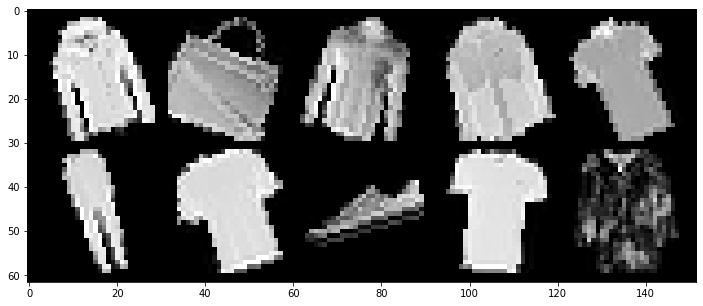

In [10]:
# Explore 1 batch  of training images
for imgs,lbls in train_loader:
    break

class_names = ['T-shirt','Trouser','Sweater','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Boot']

im = make_grid(imgs, nrow=5)
print('Labels: ', lbls)
plt.figure(figsize=(12,6))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))
plt.show()

### Build the model

In [13]:
# Define the network
"""
How many layers are input into our first fully-connected layer?
28x28 img -> 26x26 after first conv
26x26 -> 13x13 after first pooling
13x13 -> 11x11 after second conv
11x11 -> 5.5x5.5 after second pooling = 5 (L) x 5 (W) x 16 (filters)
"""

class ConvNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)  # pooling layer kernel and stride of 2
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)  # begin flattering out images. The -1 is to retain batch size
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

model = ConvNetwork()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

ConvNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Train the model

In [19]:
# 60000 training images, 10000 test images
import time
start = time.time()

epochs = 10

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for e in range(epochs):
    trn_corr = 0
    tst_corr = 0
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        # Get preds for batch
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        # Determine correct preds in batch
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print how the model is doing
        if b%1000 == 0:
            print(f'Epoch {e+1} | Batch {b}/6000 | Loss {loss.item()} | Accuracy {round(trn_corr.item()/b*10,2)}%')
    # Update train losses/accuracy for epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
    # Evaluate test data without updating params
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            # How many correct in batch
            predicted = torch.max(y_val.data, 1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr += batch_corr
    loss = criterion(y_val, y_test)
    # Update test loss/accuracy for epoch
    test_losses.append(loss)
    test_correct.append(tst_corr)

elapsed = round(time.time() - start,2)
print(f'All done! Training took {elapsed} seconds.')

Epoch 1 | Batch 1000/6000 | Loss 0.4332301616668701 | Accuracy 82.38%
Epoch 1 | Batch 2000/6000 | Loss 0.4289690852165222 | Accuracy 83.1%
Epoch 1 | Batch 3000/6000 | Loss 0.5078614950180054 | Accuracy 83.32%
Epoch 1 | Batch 4000/6000 | Loss 0.6048015356063843 | Accuracy 83.41%
Epoch 1 | Batch 5000/6000 | Loss 0.45734843611717224 | Accuracy 83.54%
Epoch 1 | Batch 6000/6000 | Loss 0.19170361757278442 | Accuracy 83.64%
Epoch 2 | Batch 1000/6000 | Loss 0.6881160140037537 | Accuracy 84.4%
Epoch 2 | Batch 2000/6000 | Loss 0.35075387358665466 | Accuracy 84.67%
Epoch 2 | Batch 3000/6000 | Loss 0.4117306172847748 | Accuracy 84.82%
Epoch 2 | Batch 4000/6000 | Loss 0.24389486014842987 | Accuracy 84.73%
Epoch 2 | Batch 5000/6000 | Loss 0.12020234763622284 | Accuracy 84.8%
Epoch 2 | Batch 6000/6000 | Loss 0.895757794380188 | Accuracy 85.02%
Epoch 3 | Batch 1000/6000 | Loss 0.28435301780700684 | Accuracy 85.18%
Epoch 3 | Batch 2000/6000 | Loss 0.5959383845329285 | Accuracy 85.56%
Epoch 3 | Batch 30

In [ ]:
# Save the model
torch.save(model.state_dict(), 'fashion_mnist.pt')

### Plot loss and accuracy against epoch

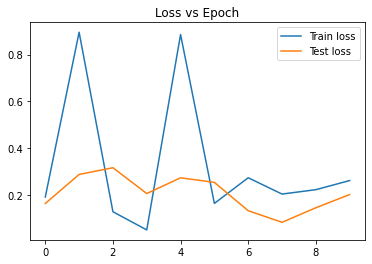

In [22]:
# Train
plt.plot([el.item() for el in train_losses], label='Train loss')
# Test/val
plt.plot([el.item() for el in test_losses], label='Test loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

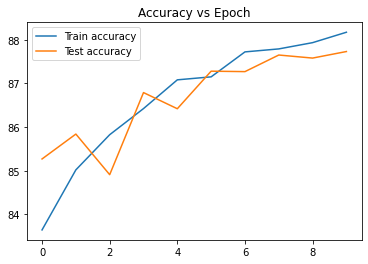

In [24]:
# Train
plt.plot([el.item()/600 for el in train_correct], label='Train accuracy')
# Test/val
plt.plot([el.item()/100 for el in test_correct], label='Test accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()

In [30]:
acc = test_correct[-1].item()/100
print(f'Final accuracy: {acc}%')

Final accuracy: 87.73%


In [33]:
# Confusion matrix
test_load_all = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

# Don't update weights
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        # correct += (predicted == y_val).sum()

import pandas as pd    
# Plot confusion matrix as heat map
arr = confusion_matrix(y_test, predicted)
cm_df = pd.DataFrame(arr, index=class_names, columns=class_names)
cm_df

,T-shirt,Trouser,Sweater,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Boot
T-shirt,817,0,16,18,4,0,131,0,13,1
Trouser,0,971,0,19,0,0,8,0,2,0
Sweater,10,1,779,8,81,0,117,0,4,0
Dress,16,11,11,872,38,0,45,0,6,1
Coat,2,4,43,23,836,0,90,0,2,0
Sandal,0,0,0,0,0,941,0,50,1,8
Shirt,136,2,70,15,93,0,670,0,14,0
Sneaker,0,0,0,0,0,1,0,990,0,9
Bag,4,0,6,1,3,2,6,2,976,0
Boot,0,0,0,0,0,6,0,71,2,921


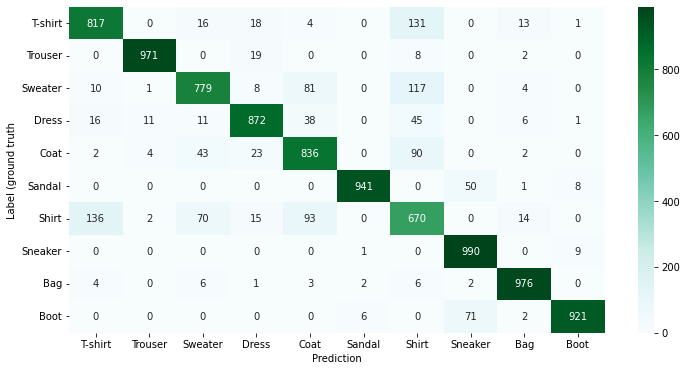

In [34]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='BuGn')
plt.xlabel('Prediction')
plt.ylabel('Label (ground truth')
plt.show()

### Pass "unseen" data to model

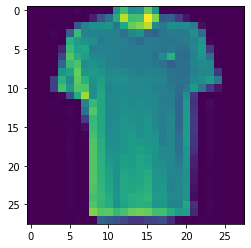

Actual label:  T-shirt


In [38]:
plt.imshow(test_data[720][0].reshape(28,28))
plt.show()
lbl = test_data[720][1]
print('Actual label: ', class_names[lbl])

In [39]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[720][0].view(1,1,28,28))  # bs, color channel, L, W
print(f'Predicted value: {class_names[new_pred.argmax().item()]}')

Predicted value: T-shirt


In [40]:
new_pred

tensor([[ -0.1003, -17.2940,  -6.6698,  -7.2340,  -9.7244, -14.4704,  -2.3714,
         -21.0723, -10.0500, -17.0532]])

In [ ]:
# The model correctly predicted a T-shirt! The second closest guess was a Shirt, which makes sense since the T-shirt vs Shirt was the most confusing classification the model faced